In [1]:
"""Scatter a particular neutrino off of many other "background" neutrinos.

Created 17 October 2023.
"""
import numpy as np
from numpy import pi, cos
from scipy.linalg import logm


def random_scatter(rho0, rho_background, n, *args, **kwargs):
    """Scatter a neutrino of interest off of background neutrinos `n` times."""
    theta = pi * np.random.rand(n)

    rho = np.array(rho0)
    yield rho

    for theta_ in theta:
        rho = scatter_background(rho, rho_background, *args, theta=theta_, **kwargs)
        yield rho


def scatter_background(rho, rho_background, *args, **kwargs):
    """Scatter a neutrino of interest with (2x2) density matrix `rho` off of a
    background neutrino with *independent* (2x2) density matrix
    `rho_background`, and return the new density matrix for the neutrino of
    interest."""
    rho_full = np.moveaxis(np.tensordot(rho, rho_background, axes=0), 1, 2)
    rho_full = scatter(rho_full, *args, **kwargs)
    rho = trace_out(rho_full)

    return rho


def scatter(rho, theta=pi/2, omega0_t=0.1):
    """Evolve the flavor density matrix of two neutrinos that scatter."""
    phase = np.exp(-2j * omega0_t * (1 - cos(theta)))

    # Time evolution matrix.
    N = 2
    N_states = 2
    U = np.zeros(2 * N * [N_states], dtype=complex)
    U[0, 0, 0, 0] = U[1, 1, 1, 1] = phase
    U[0, 1, 0, 1] = U[1, 0, 1, 0] = (phase + 1) / 2
    U[0, 1, 1, 0] = U[1, 0, 0, 1] = (phase - 1) / 2

    rho = matmul(matmul(U, rho), dagger(U))  # TODO
    return rho


def matmul(A, B):
    """Multiply two (2, 2, 2, 2) arrays as if they were (4, 4) matrices."""
    return np.einsum('ijkl,klmn', A, B)


def dagger(A):
    """Find the Hermitian conjugate of a (2, 2, 2, 2) array as if it was a
    (4, 4) matrix."""
    return np.moveaxis(A, (0, 1), (2, 3)).conjugate()


def trace_out(rho):
    """Take the trace with respect to the second neutrino."""
    return np.trace(rho, axis1=1, axis2=3)


def flavor_expval(rho):
    return rho[1, 1].real


def entropy(rho):
    return - np.trace(rho @ logm(rho)).real


In [2]:
# rho = list(random_scatter([[1/2, 1/2], [1/2, 1/2]], [[1/2, -1/2], [-1/2, 1/2]], 500))
# rho = list(random_scatter([[1/2, 0], [0, 1/2]], [[1/2, 1/2], [1/2, 1/2]], 500))
# rho = list(random_scatter([[1, 0], [0, 0]], [[1/2, 0], [0, 1/2]], 500))
rho = list(random_scatter([[1, 0], [0, 0]], [[1/2, 1/2], [1/2, 1/2]], 500))
# rho = list(random_scatter([[1, 0], [0, 0]], [[0, 0], [0, 1]], 500))

In [3]:
import matplotlib.pyplot as plt

plt.style.use('bmh')

def graph(ax, title, *args, **kwargs):
    rho = np.array(list(random_scatter(*args, **kwargs)))
    rho -= 0.5
    
    flavor = [rho_[1, 1].real for rho_ in rho]
    entropy_ = [entropy(rho_) for rho_ in rho]
    
    ax.plot(flavor, label="Flavor expval", lw=0.5)
    ax.plot(entropy_, label="Entropy")
    ax.axhline(np.log(2), c='black', ls=':', label="Maximal entropy")

    ax.set_ylim(0, 1)
    
    ax.set_title(title)
    ax.set_xlabel("Number of interactions")

    return rho, flavor, entropy_

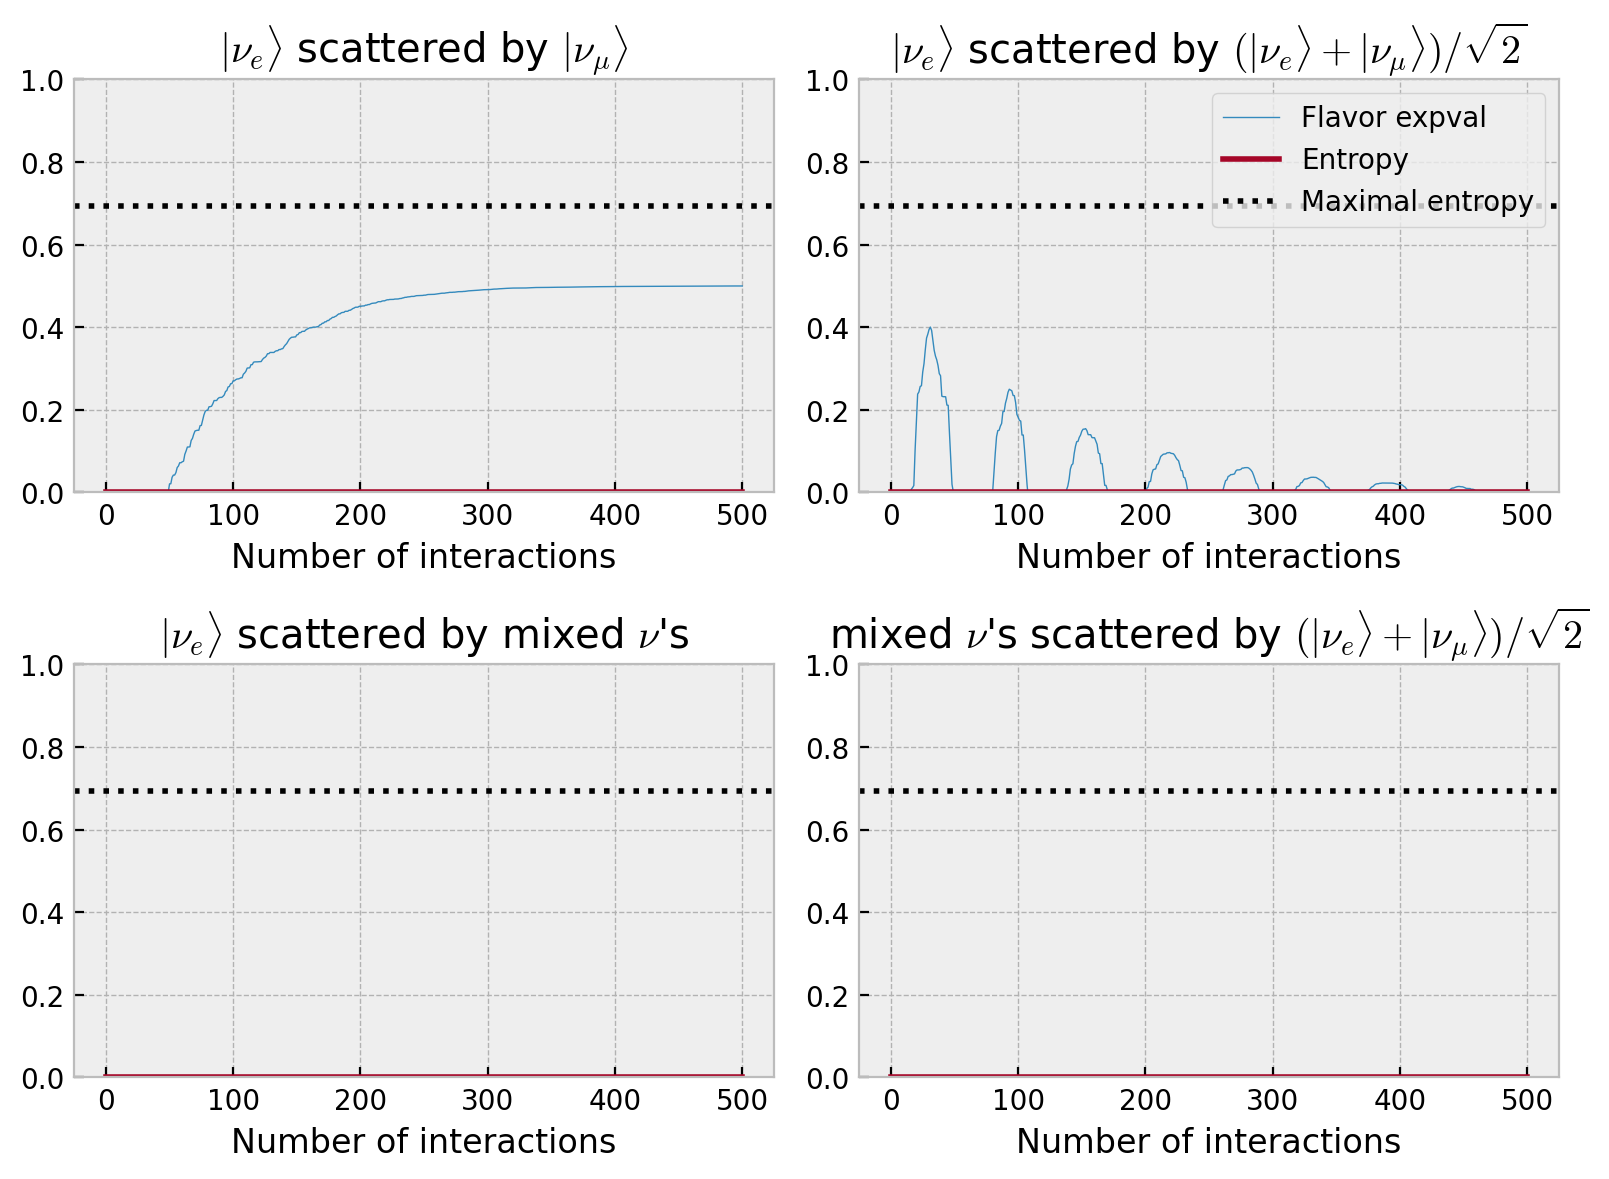

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=200)

titles = [
    r"$| \nu_e \rangle$ scattered by $| \nu_\mu \rangle$",
    r"$| \nu_e \rangle$ scattered by $(| \nu_e \rangle + | \nu_\mu \rangle) / \sqrt{2}$",
    r"$| \nu_e \rangle$ scattered by mixed $\nu$'s",
    r"mixed $\nu$'s scattered by $(| \nu_e \rangle + | \nu_\mu \rangle) / \sqrt{2}$"
]

omega0_t = 0.1
n = 500
graph(ax[0, 0], titles[0], [[1, 0], [0, 0]], [[0, 0], [0, 1]], n, omega0_t=omega0_t)
graph(ax[0, 1], titles[1], [[1, 0], [0, 0]], [[1/2, 1/2], [1/2, 1/2]], n, omega0_t=omega0_t)
graph(ax[1, 0], titles[2], [[1, 0], [0, 0]], [[1/2, 0], [0, 1/2]], n, omega0_t=omega0_t)
graph(ax[1, 1], titles[3], [[1/2, 0], [0, 1/2]], [[1/2, 1/2], [1/2, 1/2]], n, omega0_t=omega0_t)

ax[0, 1].legend(loc='upper right')

fig.tight_layout()

In [5]:
# Looks like neutrinos in pure backgrounds become pure, while neutrinos in mixed backgrounds become mixed. However, the entropy of pure neutrinos in pure backgrounds increases at first, up to a maximum, and then decreases to zero again.
# Bloch sphere?

(1e-05, 1)

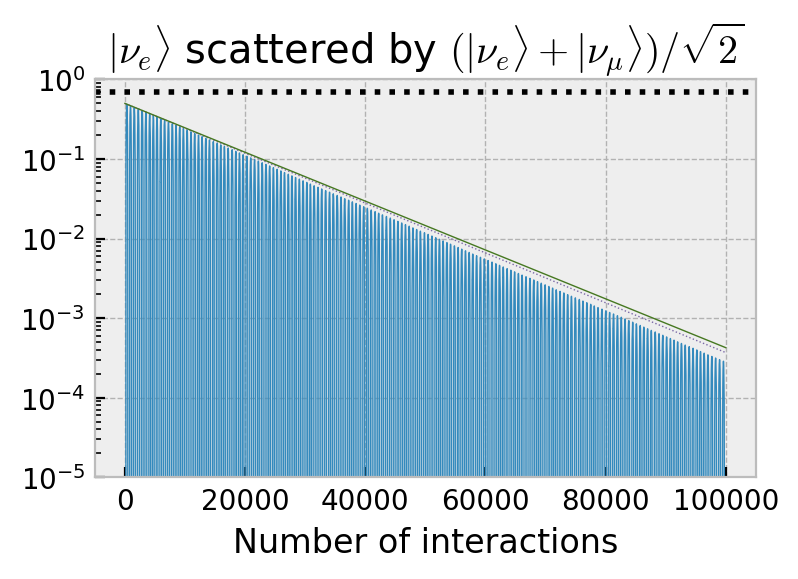

In [6]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

omega0_t = 0.01
n = 100000
rho, f, e = graph(
    ax,
    r"$| \nu_e \rangle$ scattered by $(| \nu_e \rangle + | \nu_\mu \rangle) / \sqrt{2}$",
    [[1, 0], [0, 0]],
    [[1/2, 1/2], [1/2, 1/2]],
    n,
    omega0_t=omega0_t
)
# ax.text(0.97, 0.95, rf"$\mu t = {omega0_t}$", fontsize=15, ha='right', va='top', transform=ax.transAxes,
#        bbox={'facecolor': 'white', 'boxstyle': 'round'})
# ax.legend(loc='lower right')

# Check the period.
if False:
    for i in range(17):
        ax.axvline(i * 2*pi/omega0_t, c='black')

# Check the decay time.
if True:
    x = np.arange(len(rho))
    ax.plot(0.5 * (np.exp(-omega0_t * x * (omega0_t)/(2*np.log(2)))), lw=0.5, ls=':')
    ax.plot(0.5 * (np.exp(-omega0_t * x * (omega0_t)/(np.sqrt(2)))), lw=0.5)

fig.tight_layout()

plt.yscale('log')
plt.ylim(1e-5, 1)